## Particle within radius or overlap calculations

In [1]:
#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist

#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("darkgrid")
import figurefirst

#misc
import time
np.set_printoptions(suppress=True)

In [149]:
dir_save = '../../data/Sprints/AN/'
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/HighRes/'
# df = pd.read_hdf(dir+'/Before_Declination/Windy_Expected.h5')
df=pd.read_hdf(dir+'Windy/WindyMA.h5')

In [150]:
# # dt=df.master_time[1]-df.master_time[0]


# time = []
# time.append(0)
# for i in range(1,len(df)):
#     time.append(time[i-1]+dt)
    
# df['time'] = time

In [151]:
# df.drop(df.loc[(df['time'] >= 1550) & (df['time'] < 2290)].index,inplace=True) 

In [152]:
# df = df.drop(columns=['sync_time',
#                       'distance_from_source',
#                       'nearest_from_streakline', 'relative_motion','mock',
#                       ])

In [153]:
# df.reset_index(inplace=True, drop=True) 

In [154]:
# df = df.drop(columns=['xsign'])

In [155]:
# df.drop(df.loc[(df['time'] >= 0) & (df['time'] < 310)].index,inplace=True) 

In [156]:
pi = np.pi/180
x = df.S2*np.sin((360-(df.D+13))*pi)     #eastwest
y = df.S2*np.cos((180-(df.D+13))*pi)     #northsouth

df['corrected_u'] = x
df['corrected_v'] = y



In [157]:
# pi = np.pi/180
# x = np.abs(df.S2*np.sin(((df.D+13)*pi)))
# y = np.abs(df.S2*np.cos(((df.D+13)*pi)))

# x = x*np.sign(df.U)
# y = y*np.sign(df.V)

# df['corrected_u'] = x
# df['corrected_v'] = y


In [158]:
dt=df.master_time[1]-df.master_time[0]

### Calculate Expected encounters

In [159]:
# df.insert(1,'sync_time',sync_time)

# storing the odor location in a numpy array to avoid reading pandas
source = np.array([[0,0]])
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 

distance_from_source = np.array([cdist(odor_position,source)]).flatten()
df['distance_from_source'] = distance_from_source

In [160]:
# dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/HighRes/'
# df.to_hdf(dir+'NotWindy/NotWindyMASigned.h5', key='df', mode='w')

### Relative Motion, and Distance Calculation

In [161]:
def relative_components(streakline_slope,sensor_dir,wind_dir,wind_speed,sensor_speed):
   
    ## perpendicular component
    wind_perpendicular_comp = np.sin(wrapped_angular_diff(streakline_slope,wind_dir))*wind_speed
    sensor_perpendicular_comp = np.sin(wrapped_angular_diff(streakline_slope,sensor_dir))*sensor_speed
    perp.append(wind_perpendicular_comp-sensor_perpendicular_comp)
    
    ## parallel component
    wind_parallel_comp = np.cos(wrapped_angular_diff(streakline_slope,wind_dir))*wind_speed
    sensor_parallel_comp = np.cos(wrapped_angular_diff(streakline_slope,sensor_dir))*sensor_speed
    paral.append(wind_parallel_comp-sensor_parallel_comp)
    

In [162]:
def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

def tangent_slope_direction(slope, x): 
    if (x >= 0):
        return slope
    else:
        if (slope > 0):
            return(3.14159265359 - slope)            
        else:
            return(-3.14159265359-(slope))
        
def relative_magnitude_calculation(i):
    wind_speed_magnitude = np.linalg.norm([df.corrected_u[i],df.corrected_v[i]])
    sensor_speed_magnitude = np.linalg.norm([df.gps_linear_x[i],df.gps_linear_y[i]])
    return wind_speed_magnitude, sensor_speed_magnitude

In [163]:
def get_gps_pos_vector(i):
    if(i == 0):
        gps_vector=[(df.xsrc[i+1]-df.xsrc[i]),(df.ysrc[i+1]-y[i])]
    else:
        gps_vector=[(df.xsrc[i]-df.xsrc[i-1]),(df.ysrc[i]-y[i-1])]
    
    return gps_vector

def get_st_pos_vector(streakline,pos,i):
    if(i == 1):
        st = [streakline[0,0],streakline[0,1]]  
    else:
        x = streakline[(pos),0]
        y = streakline[(pos),1]
#         x = streakline[(pos-2):(pos),0]
#         y = streakline[(pos-2):(pos),1]
#         st = [(x[0]-x[1]), y[0]-y[1]]
        st = [(x),(y)]
    
    return st

def compute_xsign_encounter(streakline, pos, i):
    u = get_gps_pos_vector(i)
    v = get_st_pos_vector(streakline,pos,i)
    x_sign.append(np.sign((np.dot(u,v))))

In [164]:
def relative_direction_calculation(streakline, pos, i):
    ## get the tangent from the nearest point
    if(pos == 0):
        x = streakline[pos:(pos+2),0]
        y = streakline[pos:(pos+2),1]
    else:
        x = streakline[(pos-1):(pos+2),0]
        y = streakline[(pos-1):(pos+2),1]
    slope_streakline,intercept_streakline=np.polyfit(x,y,1)
    
    streakline_slope=tangent_slope_direction(np.arctan(slope_streakline),streakline[pos,0] )
    
    ## find direction - source location
    sensor_dir = np.arctan2(df.gps_linear_y[i],df.gps_linear_x[i])
    wind_dir = np.arctan2(df.corrected_v[i],df.corrected_u[i])
    wind_speed, sensor_speed = relative_magnitude_calculation(i)
    
    relative_components(streakline_slope,sensor_dir,wind_dir,wind_speed,sensor_speed)    

In [165]:
def compute_ysign_encounter(streakline,pos, odor_position):
    if (streakline[pos,1]>odor_position[0][1]):
        y_sign.append(-1)
    else:
        y_sign.append(1)

In [166]:
def compute_distance(streakline, odor_position,i):
    source = np.array([[0,0]])
#     radius = np.arange(start = 4000, stop = 0, step = -1)**0.5*0.01
    streakline = np.concatenate((streakline,source))
    distance = cdist(odor_position,streakline).flatten()   # cdist compares distance for all the points in both arrays
    nearest_from_streakline.append(np.min(distance))
    pos = np.where(distance == np.amin(distance))
    relative_direction_calculation(streakline, pos[0][0],i)
    compute_ysign_encounter(streakline, pos[0][0], odor_position)
    compute_xsign_encounter(streakline,pos[0][0],i)

In [167]:
def find_streakline():
    eastwest = [np.sum(df.corrected_u[j:])*dt for j in range(0,len(df))]
    northsouth = [np.sum(df.corrected_v[j:])*dt for j in range(0,len(df))]
    return eastwest,northsouth

In [168]:
eastwest,northsouth = find_streakline()

In [139]:
# st = pd.DataFrame()
# st['eastwest']=eastwest
# st['northsouth']=northsouth

# st = pd.read_hdf(dir+'/Main/WindyStreaklineCorrected.h5')
# eastwest = st.eastwest
# northsouth= st.northsouth

# dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/HighRes/NotWindy/'
# st.to_hdf(dir+'NWStreakline.h5', key='st', mode='w')

# eastwest = df.eastwest
# northsouth = df.northsouth

In [171]:
perp = []
paral = []
nearest_from_streakline = []
distance_along_streakline = []
# odor_presence=[]
x_sign=[]
y_sign = []
for i in range(len(eastwest)-1, 385337, -1):
    odor_pos = [odor_position[i]] 
    eastwest = np.resize(np.array([eastwest-df.corrected_u[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.corrected_v[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
#     radius = np.arange(start = 6000, stop = 0, step = -1)**0.5*0.01
    compute_distance(wind_pos,odor_pos,i)
#     distance = cdist(odor_pos,wind_pos).flatten()
#     x = np.any(distance<=radius)             # generates a boolean values 
#     if x==True:
#         odor_presence.append(1)
#     else:
#         odor_presence.append(0)

In [ ]:
for i in range(len(eastwest)-1, 6000, -1):
    odor_pos = [odor_position[i]] 
    eastwest = np.resize(np.array([eastwest-df.corrected_u[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.corrected_v[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
#     radius = np.arange(start = 6000, stop = 0, step = -1)**0.5*0.01
    compute_distance(wind_pos,odor_pos,i)

In [293]:
# for i in range(len(eastwest)-1, 6000, -1):
#     odor_pos = [odor_position[i]] 
#     eastwest = np.resize(np.array([eastwest-df.corrected_u[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
#     northsouth = np.resize(np.array([northsouth-df.corrected_v[i]*dt]),(1,i)).flatten()
#     wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
#     radius = np.arange(start = 6000, stop = 0, step = -1)**0.5*0.01
#     compute_distance(wind_pos,odor_pos,i)
# #     distance = cdist(odor_pos,wind_pos).flatten()
# #     x = np.any(distance<=radius)             # generates a boolean values 
# #     if x==True:
# #         odor_presence.append(1)
# #     else:
# #         odor_presence.append(0)

In [144]:
#for the section when only the length of the elements is equal to the window value
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    
    if(i == 0):
#         radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
        distance = cdist(odor_pos,wind_pos).flatten()
        paral.append(0)
        perp.append(0)
        nearest_from_streakline.append(np.min(distance))
#         odor_presence.append(0)
        y_sign.append(1)
        x_sign.append(1)
        
    else:
        eastwest = np.resize(np.array([eastwest-df.corrected_u[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.corrected_v[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        compute_distance(wind_pos,odor_pos,i)
#         distance = cdist(odor_pos,wind_pos).flatten()
#         radius = np.arange(start = i, stop = 0, step = -1)**0.5*0.01
#         nearest_from_streakline.append(np.min(distance))
#         x = np.any(distance<=radius)             # generates a boolean values 
#         if x==True:
#             odor_presence.append(1)
#         else:
#             odor_presence.append(0)

In [145]:
## flip containers because above iteration is done in reverse order

distance_along_streakline = np.array(np.flip(distance_along_streakline)) 
nearest_from_streakline = np.array(np.flip(nearest_from_streakline)) 

# df['odorsim'] = odor_presence[::-1]
df['ysign'] = y_sign[::-1]
df['xsign'] = x_sign[::-1]
## storing in the dataframe 
# df['distance_along_streakline'] =  distance_along_streakline
# df['nearest_from_streakline'] = nearest_from_streakline
df['relative_parallel_comp']=paral[::-1]
df['relative_perpendicular_comp']=perp[::-1]

In [108]:
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/HighRes/Windy/'
df.to_hdf(dir+'WindyMASigned.h5', key='df', mode='w')

#### Extract Continuous Streakline

In [11]:
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'/NotWindy/NotWindyIF.h5')

In [12]:
angles = np.arange(45,95,5)
for x in range(len(angles)):
    time_res=2002*5 ## 50 seconds for highres 
    range_points = []
    start_angle=df.D[0]
    range_points.append(0)
    i = 0

    while i < (len(df)):
        diff = np.abs(df.D[i] - start_angle)
        if diff >= angles[x]:
            range_points.append(i)
            start_angle=df.D[i+time_res]
            i+=time_res
        else:
            i+=1
            continue

    cs=pd.DataFrame()
    j = 0
    while j < (len(range_points)):
    #     print(i)
        if(j < len(range_points)-1):
            cs = cs.append(df[range_points[j]:range_points[j+1]])        
        else:
            cs = cs.append(df[range_points[j]:])
        j+=2
    cs.reset_index(inplace=True, drop=True) 

    dt=df.time[1]-df.time[0]
    time = []
    time.append(0)
    for i in range(1,len(cs)):
        time.append(time[i-1]+dt)

    cs = cs.drop(columns=['time'])
    cs['time']=time
    cs.to_hdf(dir+'ContinuousNotWindy'+str(angles[x])+'.h5', key='cs', mode='w')

In [146]:
df["distance_from_source_a"]=np.sqrt(df.distance_from_source**2 - df.nearest_from_streakline**2)
# df.distance_from_source_a = df.distance_from_source_a*df.xsign

In [147]:
q='odor>=4.5'
dfdist=df.query(q)

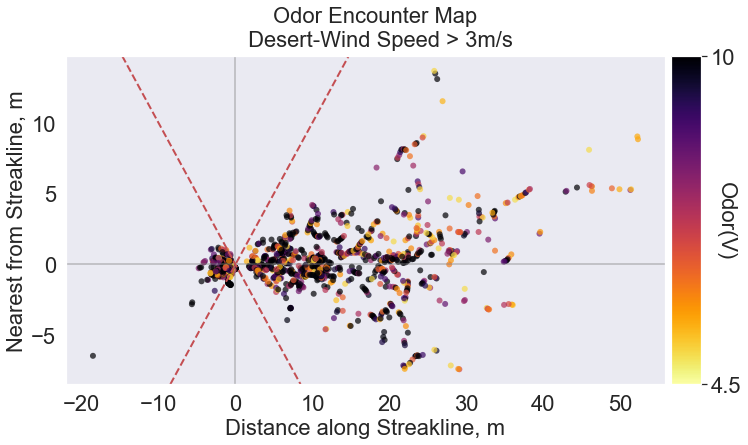

In [148]:
f,ax=plt.subplots(1,1,figsize=(10,6))
var = ax.scatter(dfdist.distance_from_source_a*dfdist.xsign,dfdist.nearest_from_streakline*dfdist.ysign,c=dfdist.odor, cmap="inferno_r",
           edgecolors='none', alpha=0.7, vmin=4, vmax=10)
ax.grid(False)
ax.axline((0,0),slope=1, linestyle='dashed', linewidth=2, color='r')
ax.axhline(0, color = 'grey', alpha=0.5)
ax.axvline(0, color = 'grey', alpha=0.5)
ax.axline((0, 0), slope=-1, linestyle='dashed', linewidth=2, color='r')
# ax.scatter(0,0,marker='o',  c='r')
# mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
#                             smart_bounds=True, xticks=[-45,0,45],yticks=[-25,0,25],linewidth=1)

ax.set_xlabel('Distance along Streakline, m')
ax.set_ylabel('Nearest from Streakline, m')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical', ticks=[4, 10])
cbar.ax.set_yticklabels(['4.5', '10'])
cbar.ax.set_ylabel('Odor(V)', rotation=-90, labelpad=-5)
cbar.solids.set(alpha=1)
f.suptitle("Odor Encounter Map \n Desert-Wind Speed > 3m/s")
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/DistanceMappingHWS.jpeg', dpi=300, bbox_inches = "tight")

In [38]:
cs.to_hdf(dir+'ContinuousNotWindy.h5', key='cs', mode='w')